In [1]:
import warnings
warnings.filterwarnings('ignore')

_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os

from tensorflow.contrib.layers import fully_connected as FC_Net
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

from sksurv.metrics import concordance_index_ipcw, concordance_index_censored, brier_score

from helpers.data_loader import *
from helpers.utils_others import *

from models.model import *
from helpers.utils_others import *

### IMPORT DATASET

In [2]:
OUT_ITERATION               = 5
data_mode                   = 'STRATCANS_v1_new2'
seed                        = 1234

(data_xs, data_xt, data_time, data_y, data_tte), (feat_static, feat_timevarying), (xt_bin_list, xt_con_list) = import_dataset_STRATCANS_v1()


# removes first and secondary pearson score
data_xs           = data_xs[:, [0,1,2,3,4,5,6]]
feat_static       = feat_static[[0,1,2,3,4,5,6]]

data_xt           = data_xt[:, :, [0,1,2,3,6,7,8,9,10]]
feat_timevarying  = feat_timevarying[[0,1,2,3,6,7,8,9,10]]
xt_con_list       = [0, 1, 2, 3, 4, 5, 6, 7]

x_dim_static      = len(feat_static)
x_dim_timevarying = len(feat_timevarying) # this includes delta

max_length                  = np.shape(data_time)[1]
num_Event                   = len(np.unique(data_y)) - 1  #number of next outcome events

data_y_new   = np.zeros([np.shape(data_y)[0], max_length, num_Event])
data_tte_new = np.zeros([np.shape(data_y)[0], max_length, num_Event])

seq_length = np.sum(np.sum(data_xt, axis=2) != 0, axis=1)

for i in range(np.shape(data_y)[0]):
    data_y_new[i, :seq_length[i], :]   = data_y[i]
    data_tte_new[i, :seq_length[i], :] = data_tte[i]

In [3]:
#====================================================
##### HYPER-PARAMETERS
mb_size                     = 64

iteration                   = 50000

keep_prob                   = 0.6
lr_train                    = 5e-4

h_dim_RNN                   = 100
h_dim_FC                    = 100

num_layers_RNN              = 2
num_layers_FC               = 3


RNN_type                    = 'GRU' #GRU, LSTM
BiRNN                       = None #if not 'None''BiRNN'

FC_active_fn                = tf.nn.relu

initial_W                   = tf.contrib.layers.xavier_initializer()

alpha                       = 1.0  #for stepahead-prediction loss
p_weibull                   = 1.0 #1.1  #1.0 # 0.5 or 1.0 performed good...


reg_scale                   = 0.


##### MAKE DICTIONARIES
# INPUT DIMENSIONS
input_dims                  = { 'x_dim_static'      : x_dim_static,
                                'x_dim_timevarying' : x_dim_timevarying, #this includes delta
                                'num_Event'         : num_Event,         #next-event types
                                'xt_con_list'       : xt_con_list,
                                'xt_bin_list'       : xt_bin_list,
                                'max_length'        : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'p_weibull'         : p_weibull,
                                'h_dim_RNN'         : h_dim_RNN,
                                'h_dim_FC'          : h_dim_FC,
                                'num_layers_RNN'    : num_layers_RNN,
                                'num_layers_FC'     : num_layers_FC,
                                'RNN_type'          : RNN_type,
                                'BiRNN'             : BiRNN,
                                'FC_active_fn'      : FC_active_fn,
                                'RNN_active_fn'     : tf.nn.tanh,
                                'initial_W'         : initial_W,
                                'reg_scale'         : reg_scale}

In [35]:
seed = 1234
out_itr = 2

In [36]:
PRED_TIMES = [0, 365, 365*2, 365*3]
EVAL_TIMES = [365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9, 365*10]

FINAL_RESULT1 = np.zeros([OUT_ITERATION, len(PRED_TIMES), len(EVAL_TIMES)])
FINAL_RESULT2 = np.zeros([OUT_ITERATION, len(PRED_TIMES), len(EVAL_TIMES)])

save_path = './{}/p{}/itr{}'.format(data_mode, p_weibull, out_itr)

if not os.path.exists(save_path + '/models/'):
    os.makedirs(save_path + '/models/')

if not os.path.exists(save_path + '/results/'):
    os.makedirs(save_path + '/results/')

(tr_data_s,te_data_s, tr_data_t,te_data_t, tr_time,te_time, tr_tte,te_tte, tr_label,te_label, tr_tte_new,te_tte_new, tr_label_new,te_label_new) = train_test_split(
    data_xs, data_xt, data_time, data_tte, data_y, data_tte_new, data_y_new, test_size=0.2, random_state=seed+out_itr
) 

(tr_data_s,va_data_s, tr_data_t,va_data_t, tr_time,va_time, tr_tte,va_tte, tr_label,va_label, tr_tte_new,va_tte_new, tr_label_new,va_label_new) = train_test_split(
    tr_data_s, tr_data_t, tr_time, tr_tte, tr_label, tr_tte_new, tr_label_new, test_size=0.2, random_state=seed+out_itr
)

tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
# config      = tf.ConfigProto(gpu_options=gpu_options)
config      = tf.ConfigProto()
sess        = tf.Session(config=config)
model       = Model_DeepHit_Weibull(sess, "Version1", input_dims, network_settings)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

CHECK_STEP = 100

min_loss = 1e8
max_flag = 50

avg_loss_tte   = 0   
avg_loss_mle   = 0
stopflag = 0


xs_mb, xt_mb, t_mb, tte_mb, m_mb = f_get_minibatch(
    mb_size, tr_data_s, tr_data_t, tr_time, tr_tte_new, tr_label_new
)

saver.restore(sess, save_path + '/models/model_tte')
enc_vars   = sess.run(model.enc_vars)
pred_vars  = sess.run(model.pred_vars)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./STRATCANS_v1_new2/p1.0/itr2/models/model_tte


In [37]:
from tensorflow.contrib.layers import fully_connected as FC_Net
from tensorflow.python.ops.rnn import _transpose_batch_time


In [38]:
h_dim_selector_RNN      = 300
num_layers_selector_RNN = 2

h_dim_selector_FC       = 300
num_layers_selector_FC  = 2

h_dim_selector_FC2      = 100
num_layers_selector_FC2 = 3


network_settings['h_dim_s1']         = h_dim_selector_RNN
network_settings['num_layers_s1']    = num_layers_selector_RNN

network_settings['h_dim_s2']         = h_dim_selector_FC
network_settings['num_layers_s2']    = num_layers_selector_FC

network_settings['h_dim_s3']         = h_dim_selector_FC2
network_settings['num_layers_s3']    = num_layers_selector_FC2

In [39]:
###############################################################################3
def Gaussian_CDF(x): #change from erf function
    return 0.5 * (1. + tf.math.erf(x / tf.math.sqrt(2.))) 

class Invase_DeepHit_Weibull:
    def __init__(self, sess, name, input_dims, network_settings):
        self.sess               = sess
        self.name               = name

        # INPUT DIMENSIONS
        self.x_dim_static       = input_dims['x_dim_static']
        self.x_dim_timevarying  = input_dims['x_dim_timevarying'] #this includes feature dim + 1 (dela)
                
        self.num_Event          = input_dims['num_Event'] #number of event types.
        self.max_length         = input_dims['max_length']
        
        # NETWORK HYPER-PARMETERS
        self.p_weibull          = network_settings['p_weibull']
        
        self.h_dim1             = network_settings['h_dim_RNN']
        self.h_dim2             = network_settings['h_dim_FC']
        self.num_layers_RNN     = network_settings['num_layers_RNN']
        self.num_layers_FC      = network_settings['num_layers_FC']
        
        self.h_dim_s1           = network_settings['h_dim_s1']  #selector rnn
        self.num_layers_s1      = network_settings['num_layers_s1'] #selector rnn

        self.h_dim_s2           = network_settings['h_dim_s2']  #selector fcnet (temporal)
        self.num_layers_s2      = network_settings['num_layers_s2'] #selector fcnet (temporal)
        
        self.h_dim_s3           = network_settings['h_dim_s3']  #selector fcnet (static)
        self.num_layers_s3      = network_settings['num_layers_s3'] #selector fcnet (static)

        self.RNN_type           = network_settings['RNN_type']
        self.BiRNN              = network_settings['BiRNN']

        self.FC_active_fn       = network_settings['FC_active_fn']
        self.RNN_active_fn      = network_settings['RNN_active_fn']
        self.initial_W          = network_settings['initial_W']
        self.reg_scale          = network_settings['reg_scale']
        
        self.reg_W              = tf.contrib.layers.l1_regularizer(scale=self.reg_scale)
        self.reg_W_out          = tf.contrib.layers.l1_regularizer(scale=self.reg_scale)


        self._build_net()


    def _build_net(self):
        with tf.variable_scope(self.name):
            #### PLACEHOLDER DECLARATION
            self.lr_rate     = tf.placeholder(tf.float32)
            self.keep_prob   = tf.placeholder(tf.float32)  #keeping rate            
            
            self.a           = tf.placeholder(tf.float32, name='alpha') #step-ahead prediction loss          
  
            self.xs          = tf.placeholder(tf.float32, shape=[None, self.x_dim_static])
            self.xt          = tf.placeholder(tf.float32, shape=[None, self.max_length, self.x_dim_timevarying], name='input')
            
            self.mb_size     = tf.placeholder(tf.int32, [], name='batch_size')
#             self.mb_size     = tf.shape(self.xs)[0]
            
            self.is_training = tf.placeholder(tf.bool, [], name='trainiin_indicator')            
            self.tau         = tf.placeholder(tf.float32, shape=[None, 1])  #at evaluation time (required for risk prediction)
            
                        
            '''
                ##### CREATE MASK
                    - rnn_mask1 [None, 1] (to collect the last value - Lambda & z)
                    - rnn_mask2 (for the last value - get lambda)
                    - rnn_mask3 (for the last value - get lambda)
            '''
            seq_length = get_seq_length(self.xt)
            tmp_range = tf.expand_dims(tf.range(0, self.max_length, 1), axis=0)
            self.rnn_mask1 = tf.cast(tf.equal(tmp_range, tf.expand_dims(seq_length - 1, axis=1)), tf.float32)
            self.rnn_mask2 = tf.cast(tf.less_equal(tmp_range, tf.expand_dims(seq_length - 1, axis=1)), tf.float32)
            self.rnn_mask3 = tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim_timevarying]) #for hisotry (1...J-1)
            
            self.p = tf.constant(self.p_weibull, name="P")
            
            ### BLACKBOX MODEL
            with tf.variable_scope('blackbox'):
                inputs_ta = tf.TensorArray(
                    dtype=tf.float32, size=self.max_length
                ).unstack(_transpose_batch_time(self.xt), name = 'Rnn_Input')

                # estimator network (i.e., predictions on the log_lambda)           
                def prediction_network(h_, reuse=tf.AUTO_REUSE):
                    # outputs log_lambda i.e., lambda = tf.exp(out)
                    with tf.variable_scope('prediction_net', reuse=reuse):
                        out = utils.create_FCNet(h_, (self.num_layers_FC), self.h_dim2, self.FC_active_fn, self.num_Event, None, self.initial_W, self.reg_W, self.keep_prob)
    #                     out = tf.nn.softplus(h_)
                    return out

                '''
                    ##### DEFINE LOOP FUNCTION FOR TEMPORAL ATTENTION
                        - loop_state[0]: attention power (i.e., e_{j})
                        - loop_state[1]: hidden states
                '''
                def loop_fn_mle(time, cell_output, cell_state, loop_state):

                    emit_output = cell_output 

                    if cell_output is None:  # time == 0
                        next_cell_state = cell.zero_state(self.mb_size, tf.float32)
                        next_loop_state = loop_state_ta
                    else:
                        next_cell_state = cell_state
                        tmp_z = utils.create_concat_state(next_cell_state, self.num_layers_RNN, self.RNN_type, self.BiRNN)

                        tmp_loglambda   = prediction_network(tmp_z)                    

                        next_loop_state = (
                            loop_state[0].write(time-1, tmp_z),         # save all the hidden states continuous
                            loop_state[1].write(time-1, tmp_loglambda), # save all the loglambdas
                        )

    #                 elements_finished = (time >= seq_length)
                    elements_finished = (time >= self.max_length)

                    #this gives the break-point (no more recurrence after the max_length)
                    finished = tf.reduce_all(elements_finished)    
                    next_input = tf.cond(finished, 
                                         lambda: tf.zeros([self.mb_size, self.x_dim_timevarying+self.x_dim_static], dtype=tf.float32),  # [xs, xt_hist]
                                         lambda: tf.concat([inputs_ta.read(time), self.xs], axis=1))
                    return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)

                
                '''
                    ##### RNN NETWORK
                        - (INPUT)  inputs_ta: TensorArray with [max_length, mb_size, 1+self.x_dim_timevarying+self.x_dim_static]
                        - (OUTPUT) rnn_outputs_ta: TensorArray
                        - (OUTPUT) rnn_final_state: Tensor
                        - (OUTPUT) loop_state_ta: 2 TensorArrays (e values and hidden states)
                '''
                cell = utils.create_rnn_cell(self.h_dim1, self.num_layers_RNN, self.keep_prob, 
                                             self.RNN_type, self.RNN_active_fn)

                #define the loop_state TensorArray for information from rnn time steps
                loop_state_ta = (
                    tf.TensorArray(size=self.max_length, dtype=tf.float32),  #hidden states continuous(j=1,...,J)
                    tf.TensorArray(size=self.max_length, dtype=tf.float32),  #lambdas (j=1,...,J)
                )  

                rnn_outputs_ta, _, loop_state_ta = tf.nn.raw_rnn(cell, loop_fn_mle)

                self.rnn_states           = _transpose_batch_time(loop_state_ta[0].stack())
                self.ys                   = _transpose_batch_time(loop_state_ta[1].stack())
                self.ys                   = tf.exp(self.ys) #log_lambda -> lambda                       

                self.z      = tf.reduce_sum(
                    self.rnn_states * tf.tile(tf.expand_dims(self.rnn_mask1, axis=2), [1,1,self.h_dim1*self.num_layers_RNN]), axis=1
                )
                self.y      = tf.reduce_sum(
                    self.ys * tf.tile(tf.expand_dims(self.rnn_mask1, axis=2), [1,1,self.num_Event]), axis=1
                )



                self.risk     = div(self.y, tf.reduce_sum(self.y, axis=1, keepdims=True)) * (1. - tf.exp(- tf.pow(tf.reduce_sum(self.y, axis=1, keepdims=True) * self.tau, self.p)))


            ##### SELECTOR
            self.sigma        = tf.placeholder(tf.float32, [], name='sigma')            
            with tf.variable_scope('selector'):
                inputs_ta_selector = tf.TensorArray(
                    dtype=tf.float32, size=self.max_length
                ).unstack(_transpose_batch_time(self.xt), name = 'Rnn_Input_Selector')

                ### DEFINE RNN-SELECTOR
                def selector_rnn(x_, o_dim_, num_layers_=1, h_dim_=100, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE):
                    with tf.variable_scope('selector_rnn', reuse=reuse):
                        if num_layers_ == 1:
                            out =  tf.contrib.layers.fully_connected(inputs=x_, num_outputs=o_dim_, activation_fn=None, scope='predictor_out')
                        else: #num_layers > 1
                            for tmp_layer in range(num_layers_-1):
                                if tmp_layer == 0:
                                    net = x_
                                net = tf.contrib.layers.fully_connected(inputs=net, num_outputs=h_dim_, activation_fn=activation_fn, scope='predictor_'+str(tmp_layer))
                                net = tf.nn.dropout(net, keep_prob=self.keep_prob)
                            out =  tf.contrib.layers.fully_connected(inputs=net, num_outputs=o_dim_, activation_fn=None, scope='predictor_out')  
                    return out


                ### DEFINE LOOP FUNCTION FOR SELECTOR (RNN-INVASE)
                def loop_fn_selector(time, cell_output, cell_state, loop_state):

                    emit_output = cell_output 

                    if cell_output is None:  # time == 0
                        next_cell_state = cell_selector.zero_state(self.mb_size, tf.float32)
                        next_loop_state = loop_state_ta_selector
                    else:
                        next_cell_state = cell_state
                        tmp_z  = utils.create_concat_state(next_cell_state, self.num_layers_s1, self.RNN_type, self.BiRNN)
                        tmp_s  = selector_rnn(tmp_z, self.x_dim_timevarying, self.num_layers_s2, self.h_dim_s2, self.FC_active_fn)        

                        next_loop_state = loop_state.write(time-1, tmp_s) # save all the selector_net output (i.e., pi)

                    elements_finished = (time >= self.max_length)

                    #this gives the break-point (no more recurrence after the max_length)
                    finished = tf.reduce_all(elements_finished)    

                    next_input = tf.cond(finished, 
                                         lambda: tf.zeros([self.mb_size, self.x_dim_static+self.x_dim_timevarying], dtype=tf.float32),  # [xs, xt_hist]
                                         lambda: tf.concat([inputs_ta_selector.read(time), self.xs], axis=1))                    
                    return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)

                '''
                    ##### CREATE RNN NETWORK
                        - (INPUT)  inputs_ta: TensorArray with [max_length, mb_size, x_dim] #x_dim included delta
                        - (OUTPUT) 
                            . zs     = rnn states (h) in LSTM/GRU             ; [mb_size, max_length, z_dim]
                            . pis    = output of predictor taking zs as inputs; [mb_size, max_length, x_dim]

                '''
                cell_selector    = utils.create_rnn_cell(
                    self.h_dim_s1, self.num_layers_s1, 
                    self.keep_prob, self.RNN_type, self.RNN_active_fn
                )

                #define the loop_state TensorArray for information from rnn time steps
                loop_state_ta_selector = tf.TensorArray(size=self.max_length, dtype=tf.float32, clear_after_read=False)            

                _, _, loop_state_ta_selector = tf.nn.raw_rnn(cell_selector, loop_fn_selector) #, parallel_iterations=1)

                self.pis_temporal = _transpose_batch_time(loop_state_ta_selector.stack()) + 0.5 #0.5 is added because the initialized ones has 0 mean.
                self.pis_temporal = self.pis_temporal * tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim_timevarying])
                
                noise             = tf.random_normal(shape=[self.mb_size, self.max_length, self.x_dim_timevarying], mean=0.0, stddev=1.0)
                self.stg_temporal = tf.clip_by_value(self.pis_temporal + self.sigma * noise * tf.cast(self.is_training, tf.float32), 0., 1.0, name='stg_temporal') #hardsigmoid function
                               
                
                ### DEFINE RNN-SELECTOR
                def selector_fc(x_, o_dim_, num_layers_=1, h_dim_=100, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE):
                    with tf.variable_scope('selector_fc', reuse=reuse):
                        if num_layers_ == 1:
                            out =  tf.contrib.layers.fully_connected(inputs=x_, num_outputs=o_dim_, activation_fn=None, scope='predictor_out')
                        else: #num_layers > 1
                            for tmp_layer in range(num_layers_-1):
                                if tmp_layer == 0:
                                    net = x_
                                net = tf.contrib.layers.fully_connected(inputs=net, num_outputs=h_dim_, activation_fn=activation_fn, scope='predictor_'+str(tmp_layer))
                                net = tf.nn.dropout(net, keep_prob=self.keep_prob)
                            out =  tf.contrib.layers.fully_connected(inputs=net, num_outputs=o_dim_, activation_fn=None, scope='predictor_out')  
                    return out
                
                self.pis_static  = selector_fc(self.xs, self.x_dim_static, self.num_layers_s3, self.h_dim_s3, self.FC_active_fn) + 0.5 #0.5 is added because the initialized ones has 0 mean.
                noise            = tf.random_normal(shape=[self.mb_size, self.x_dim_static], mean=0.0, stddev=1.0)
                self.stg_static  = tf.clip_by_value(self.pis_static + self.sigma * noise * tf.cast(self.is_training, tf.float32), 0., 1.0, name='stg_static') #hardsigmoid function
                
            
            ##### INTERPRETER
            self.beta        = tf.placeholder(tf.float32, name='coef_sparsity')         

            with tf.variable_scope('interpreter'):
                
                self.xt_tilde = self.xt * self.stg_temporal
                self.xs_tilde = self.xs * self.stg_static
                
                inputs_ta_tilde = tf.TensorArray(
                    dtype=tf.float32, size=self.max_length
                ).unstack(_transpose_batch_time(self.xt_tilde), name = 'Rnn_Input_Interpreter')

                # estimator network (i.e., predictions on the log_lambda)           
                def prediction_network_interpreter(h_, reuse=tf.AUTO_REUSE):
                    # outputs log_lambda i.e., lambda = tf.exp(out)
                    with tf.variable_scope('prediction_net', reuse=reuse):
                        out = utils.create_FCNet(h_, (self.num_layers_FC), self.h_dim2, self.FC_active_fn, self.num_Event, None, self.initial_W, self.reg_W, self.keep_prob)
    #                     out = tf.nn.softplus(h_)
                    return out

                '''
                    ##### DEFINE LOOP FUNCTION FOR TEMPORAL ATTENTION
                        - loop_state[0]: attention power (i.e., e_{j})
                        - loop_state[1]: hidden states
                '''
                def loop_fn_mle(time, cell_output, cell_state, loop_state):

                    emit_output = cell_output 

                    if cell_output is None:  # time == 0
                        next_cell_state = cell.zero_state(self.mb_size, tf.float32)
                        next_loop_state = loop_state_ta_tilde
                    else:
                        next_cell_state = cell_state
                        tmp_z = utils.create_concat_state(next_cell_state, self.num_layers_RNN, self.RNN_type, self.BiRNN)

                        tmp_loglambda   = prediction_network_interpreter(tmp_z)                    

                        next_loop_state = (
                            loop_state[0].write(time-1, tmp_z),         # save all the hidden states continuous
                            loop_state[1].write(time-1, tmp_loglambda), # save all the loglambdas
                        )

    #                 elements_finished = (time >= seq_length)
                    elements_finished = (time >= self.max_length)

                    #this gives the break-point (no more recurrence after the max_length)
                    finished = tf.reduce_all(elements_finished)    
                    next_input = tf.cond(finished, 
                                         lambda: tf.zeros([self.mb_size, self.x_dim_timevarying+self.x_dim_static], dtype=tf.float32),  # [xs, xt_hist]
                                         lambda: tf.concat([inputs_ta_tilde.read(time), self.xs_tilde], axis=1))
                    return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)

                
                '''
                    ##### RNN NETWORK
                        - (INPUT)  inputs_ta: TensorArray with [max_length, mb_size, 1+self.x_dim_timevarying+self.x_dim_static]
                        - (OUTPUT) rnn_outputs_ta: TensorArray
                        - (OUTPUT) rnn_final_state: Tensor
                        - (OUTPUT) loop_state_ta: 2 TensorArrays (e values and hidden states)
                '''
                cell = utils.create_rnn_cell(self.h_dim1, self.num_layers_RNN, self.keep_prob, 
                                             self.RNN_type, self.RNN_active_fn)

                #define the loop_state TensorArray for information from rnn time steps
                loop_state_ta_tilde = (
                    tf.TensorArray(size=self.max_length, dtype=tf.float32),  #hidden states continuous(j=1,...,J)
                    tf.TensorArray(size=self.max_length, dtype=tf.float32),  #lambdas (j=1,...,J)
                )  

                rnn_outputs_ta_tilde, _, loop_state_ta_tilde = tf.nn.raw_rnn(cell, loop_fn_mle)

                self.rnn_states_tilde     = _transpose_batch_time(loop_state_ta_tilde[0].stack())
                self.ys_tilde             = _transpose_batch_time(loop_state_ta_tilde[1].stack())
                self.ys_tilde             = tf.exp(self.ys_tilde) #log_lambda -> lambda                       

                self.z_tilde      = tf.reduce_sum(
                    self.rnn_states_tilde * tf.tile(tf.expand_dims(self.rnn_mask1, axis=2), [1,1,self.h_dim1*self.num_layers_RNN]), axis=1
                )
                self.y_tilde      = tf.reduce_sum(
                    self.ys_tilde * tf.tile(tf.expand_dims(self.rnn_mask1, axis=2), [1,1,self.num_Event]), axis=1
                )
                
                self.risk_tilde   = div(self.y_tilde, tf.reduce_sum(self.y_tilde, axis=1, keepdims=True)) * (1. - tf.exp(- tf.pow(tf.reduce_sum(self.y_tilde, axis=1, keepdims=True) * self.tau, self.p)))
                
                
            def kl_distance_weibull(v1, v2): 
                return 0.5 *( (div(v1, v2)**self.p) + (div(v2, v1)**self.p) )
            
            loss                  = tf.reshape(0.5 *(kl_distance_weibull(self.ys, self.ys_tilde) + kl_distance_weibull(self.ys_tilde, self.ys) ), [-1, model.max_length])
            self.loss_kl          = div(tf.reduce_sum(self.rnn_mask2 * loss, axis=1), tf.reduce_sum(self.rnn_mask2, axis=1))
            self.loss_kl          = tf.reduce_mean(self.loss_kl)
            self.loss_sparsity_t  = div(tf.reduce_sum(self.rnn_mask2 * tf.reduce_mean(Gaussian_CDF(self.pis_temporal / self.sigma), axis=-1), axis=1), tf.reduce_sum(self.rnn_mask2, axis=1) )
            self.loss_sparsity_s  = tf.reduce_mean(Gaussian_CDF(self.pis_static / self.sigma), axis=1)
            self.loss_sparsity    = tf.reduce_mean(self.loss_sparsity_s + self.loss_sparsity_t )
            
            self.loss_invase      = self.loss_kl + self.beta*self.loss_sparsity
                
            ##### VARIABLES
            self.blackbox_vars        = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + '/blackbox')        
            self.blackbox_pred_vars   = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + '/blackbox/rnn/prediction_net') 
            self.blackbox_enc_vars    = [tmp_var for tmp_var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + '/blackbox/rnn/') if tmp_var not in self.blackbox_pred_vars]

            self.selector_vars           = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + '/selector')        

            self.interpreter_vars        = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + '/interpreter')        
            self.interpreter_pred_vars   = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + '/interpreter/rnn/prediction_net') 
            self.interpreter_enc_vars    = [tmp_var for tmp_var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + '/interpreter/rnn/') if tmp_var not in self.interpreter_pred_vars]
                
            
            self.solver_invase      = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.loss_invase, var_list=self.selector_vars+self.interpreter_vars)
            self.solver_selector    = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.loss_invase, var_list=self.selector_vars)
            self.solver_interpreter = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.loss_invase, var_list=self.interpreter_vars)
            
            
    def train(self, xs_, xt_, beta_, sigma_=0.5, keep_prob=1.0, lr_train=1e-3):
        return self.sess.run([self.solver_invase, self.loss_invase, self.loss_sparsity], 
                             feed_dict={self.xs:xs_, self.xt:xt_, self.beta:beta_, 
                                        self.sigma:sigma_, self.mb_size: np.shape(xt_)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train, self.is_training:True})

    
    def train_selector(self, xs_, xt_, beta_, sigma_=0.5, keep_prob=1.0, lr_train=1e-3):
        return self.sess.run([self.solver_selector, self.loss_invase, self.loss_sparsity], 
                             feed_dict={self.xs:xs_, self.xt:xt_, self.beta:beta_, 
                                        self.sigma:sigma_, self.mb_size: np.shape(xt_)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train, self.is_training:True})

    
    def train_interpreter(self, xs_, xt_, beta_, sigma_=0.5, keep_prob=1.0, lr_train=1e-3):
        return self.sess.run([self.solver_interpreter, self.loss_invase, self.loss_sparsity], 
                             feed_dict={self.xs:xs_, self.xt:xt_, self.beta:beta_, 
                                        self.sigma:sigma_, self.mb_size: np.shape(xt_)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train, self.is_training:True})

    
    
    def get_cost(self, xs_, xt_, beta_, sigma_=0.5):
        return self.sess.run([self.loss_invase, self.loss_sparsity], 
                             feed_dict={self.xs:xs_, self.xt:xt_, self.beta:beta_, 
                                        self.sigma:sigma_, self.mb_size: np.shape(xt_)[0], self.keep_prob:1.0, self.is_training:False})
    
    
    ### blackbox predictions
    def get_risk(self, xs_, xt_, tau_):
        return self.sess.run(self.risk, 
                             feed_dict={self.xs:xs_, self.xt: xt_, self.tau: tau_,
                                        self.mb_size: np.shape(xt_)[0], self.keep_prob:1.0, self.is_training:False})
    
    def get_zs(self, xs_, xt_):
        return self.sess.run(self.rnn_states, 
                             feed_dict={self.xs:xs_, self.xt:xt_, 
                                        self.mb_size: np.shape(xt_)[0], self.keep_prob: 1.0, self.is_training:False})
    
    def get_final_z(self, xs_, xt_):
        return self.sess.run(self.z, 
                             feed_dict={self.xs:xs_, self.xt:xt_, 
                                        self.mb_size: np.shape(xt_)[0], self.keep_prob: 1.0, self.is_training:False})
    
    def get_lambdas(self, xs_, xt_):
        return self.sess.run(self.ys, 
                             feed_dict={self.xs:xs_, self.xt:xt_, 
                                        self.mb_size: np.shape(xt_)[0], self.keep_prob: 1.0, self.is_training:False})
    

    def get_final_lambda(self, xs_, xt_):
        return self.sess.run(self.y, 
                             feed_dict={self.xs:xs_, self.xt:xt_, 
                                        self.mb_size: np.shape(xt_)[0], self.keep_prob: 1.0, self.is_training:False})
    
    ### interpreter estimations
    def get_risk_estimate(self, xs_, xt_, tau_, sigma_=0.5):
        return self.sess.run(self.risk_tilde, 
                             feed_dict={self.xs:xs_, self.xt: xt_, self.tau: tau_,
                                        self.mb_size: np.shape(xt_)[0], self.sigma: sigma_, self.keep_prob:1.0, self.is_training:False})
    
    def get_final_z_estimate(self, xs_, xt_, sigma_=0.5):
        return self.sess.run(self.z_tilde, 
                             feed_dict={self.xs:xs_, self.xt:xt_, 
                                        self.mb_size: np.shape(xt_)[0], self.sigma: sigma_, self.keep_prob: 1.0, self.is_training:False})
    
    def get_lambdas_estimate(self, xs_, xt_, sigma_=0.5):
        return self.sess.run(self.ys_tilde, 
                             feed_dict={self.xs:xs_, self.xt:xt_, 
                                        self.mb_size: np.shape(xt_)[0], self.sigma: sigma_, self.keep_prob: 1.0, self.is_training:False})
    
    def get_final_lambda_estimate(self, xs_, xt_, sigma_=0.5):
        return self.sess.run(self.y_tilde, 
                             feed_dict={self.xs:xs_, self.xt:xt_, 
                                        self.mb_size: np.shape(xt_)[0], self.sigma: sigma_, self.keep_prob: 1.0, self.is_training:False})
    
    def get_pis(self, xs_, xt_, sigma_=0.5):
        return self.sess.run([self.pis_static, self.pis_temporal, self.rnn_mask2],
                            feed_dict={self.xs:xs_, self.xt:xt_, 
                                        self.mb_size: np.shape(xt_)[0], self.sigma: sigma_, self.keep_prob: 1.0, self.is_training:False})

In [40]:
tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
# config      = tf.ConfigProto(gpu_options=gpu_options)
config      = tf.ConfigProto()
sess        = tf.Session(config=config)
model       = Invase_DeepHit_Weibull(sess, "Version1_Invase", input_dims, network_settings)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


In [41]:
for n in range(len(enc_vars)):
    _ = sess.run(tf.assign(model.blackbox_enc_vars[n], enc_vars[n]))
#     _ = sess.run(tf.assign(model.interpreter_enc_vars[n], enc_vars[n]))

for n in range(len(pred_vars)):
    _ = sess.run(tf.assign(model.blackbox_pred_vars[n], pred_vars[n]))
#     _ = sess.run(tf.assign(model.interpreter_pred_vars[n], pred_vars[n]))

In [61]:
beta    = 0.5
mb_size = 64
lr_rate = 1e-4
keep_prob = 1.0

In [62]:
PRED_TIMES = [0, 365, 365*2, 365*3]
EVAL_TIMES = [365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9, 365*10]

FINAL_RESULT1 = np.zeros([OUT_ITERATION, len(PRED_TIMES), len(EVAL_TIMES)])
FINAL_RESULT2 = np.zeros([OUT_ITERATION, len(PRED_TIMES), len(EVAL_TIMES)])



tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
# config      = tf.ConfigProto(gpu_options=gpu_options)
config      = tf.ConfigProto()
sess        = tf.Session(config=config)
model       = Invase_DeepHit_Weibull(sess, "Version1_Invase", input_dims, network_settings)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for n in range(len(enc_vars)):
    _ = sess.run(tf.assign(model.blackbox_enc_vars[n], enc_vars[n]))
    _ = sess.run(tf.assign(model.interpreter_enc_vars[n], enc_vars[n]))

for n in range(len(pred_vars)):
    _ = sess.run(tf.assign(model.blackbox_pred_vars[n], pred_vars[n]))
    _ = sess.run(tf.assign(model.interpreter_pred_vars[n], pred_vars[n]))

CHECK_STEP = 100

min_loss = 1e8
max_flag = 50

avg_loss_invase   = 0   
avg_loss_sparsity = 0
stopflag = 0

print( "MAIN TRAINING ...")
for itr in range(iteration):
    xs_mb, xt_mb, t_mb, tte_mb, m_mb = f_get_minibatch(
        mb_size, tr_data_s, tr_data_t, tr_time, tr_tte_new, tr_label_new
    )

    DATA       = (xs_mb, xt_mb, t_mb, tte_mb, m_mb)

#     _, loss_invase, loss_sparsity = model.train(xs_mb, xt_mb, beta_=beta, sigma_=0.5, keep_prob=keep_prob, lr_train=lr_train)   
    _, loss_invase, loss_sparsity = model.train_interpreter(xs_mb, xt_mb, beta_=beta, sigma_=0.5, keep_prob=keep_prob, lr_train=1e-3)   
    _, loss_invase, loss_sparsity = model.train_selector(xs_mb, xt_mb, beta_=beta, sigma_=0.5, keep_prob=keep_prob, lr_train=1e-4)   
    

    avg_loss_invase   += loss_invase/CHECK_STEP
    avg_loss_sparsity += loss_sparsity/CHECK_STEP

    if (itr+1)%CHECK_STEP == 0:
        stopflag += 1

        va_loss_invase, va_loss_sparsity = model.get_cost(va_data_s, va_data_t, beta_=beta, sigma_=0.5)   

        print('|| Epoch:{0:05d} | TR_Loss_invase:{1:0.4f} |  TR_Loss_sparse:{2:0.4f} || VA_Loss_invase:{3:0.4f} || VA_Loss_sparse:{4:0.4f} ||'.format(
            itr + 1, avg_loss_invase, avg_loss_sparsity, va_loss_invase, va_loss_sparsity))
        
        pis, pit, m2 = model.get_pis(tr_data_s, tr_data_t)
        print(np.mean(pis, axis=0))

        avg_loss_invase  = 0   
        avg_loss_sparsity  = 0

        if min_loss > va_loss_invase:
            stopflag = 0
            min_loss = va_loss_invase

            saver.save(sess, save_path + '/models_invase/model_invase')
            print('saved...')

            RESULT1 = np.zeros([len(PRED_TIMES), len(EVAL_TIMES)])
            RESULT2 = np.zeros([len(PRED_TIMES), len(EVAL_TIMES)])

            for p_idx, pred_time in enumerate(PRED_TIMES):
                p_idx_te  = te_tte >= pred_time
                p_idx_tr  = tr_tte >= pred_time

                tmp_pred, tmp_idx = f_get_prediction_invase(model, te_data_s, te_data_t, te_time, EVAL_TIMES, pred_time_= pred_time)


                tmp_y = tr_label[p_idx_tr]
                tmp_t = tr_tte[p_idx_tr] - pred_time

                tr_y_structured =  [(tmp_y[i], tmp_t[i]) for i in range(len(tmp_y))]
                tr_y_structured = np.array(tr_y_structured, dtype=[('status', 'bool'),('time','<f8')])

                tmp_y = te_label[p_idx_te]
                tmp_t = te_tte[p_idx_te] - pred_time

                te_y_structured =  [(tmp_y[i], tmp_t[i]) for i in range(len(tmp_y))]
                te_y_structured = np.array(te_y_structured, dtype=[('status', 'bool'),('time','<f8')])


                for e_idx, eval_time in enumerate(EVAL_TIMES):
                    if np.sum((tmp_t<=eval_time) & (tmp_y==1)) > 0:
                        RESULT1[p_idx, e_idx] = concordance_index_ipcw(tr_y_structured, te_y_structured, tmp_pred[p_idx_te][:, e_idx], tau=eval_time)[0]
                        RESULT2[p_idx, e_idx] = brier_score(tr_y_structured, te_y_structured, 1.- tmp_pred[p_idx_te][:, e_idx], times=eval_time)[1][0]

            print(RESULT1)

    if stopflag >= max_flag:
        print('model trained...')
        break

# saver.restore(sess, save_path + '/models_invase/model_invase')

# PRED_TIMES = [0, 365, 365*2, 365*3]
# EVAL_TIMES = [365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9, 365*10]

# RESULT1 = -1. * np.ones([len(PRED_TIMES), len(EVAL_TIMES)])
# RESULT2 = -1. * np.ones([len(PRED_TIMES), len(EVAL_TIMES)])

# for p_idx, pred_time in enumerate(PRED_TIMES):
#     p_idx_te  = te_tte >= pred_time
#     p_idx_tr  = tr_tte >= pred_time

#     tmp_pred, tmp_idx = f_get_prediction(model, te_data_s, te_data_t, te_time, EVAL_TIMES, pred_time_= pred_time)


#     tmp_y = tr_label[p_idx_tr]
#     tmp_t = tr_tte[p_idx_tr] - pred_time

#     tr_y_structured =  [(tmp_y[i], tmp_t[i]) for i in range(len(tmp_y))]
#     tr_y_structured = np.array(tr_y_structured, dtype=[('status', 'bool'),('time','<f8')])

#     tmp_y = te_label[p_idx_te]
#     tmp_t = te_tte[p_idx_te] - pred_time

#     te_y_structured =  [(tmp_y[i], tmp_t[i]) for i in range(len(tmp_y))]
#     te_y_structured = np.array(te_y_structured, dtype=[('status', 'bool'),('time','<f8')])


#     for e_idx, eval_time in enumerate(EVAL_TIMES):
#         if np.sum((tmp_t<=eval_time) & (tmp_y==1)) > 0:
#             RESULT1[p_idx, e_idx] = concordance_index_ipcw(tr_y_structured, te_y_structured, tmp_pred[p_idx_te][:, e_idx], tau=eval_time)[0]
#             RESULT2[p_idx, e_idx] = brier_score(tr_y_structured, te_y_structured, 1.- tmp_pred[p_idx_te][:, e_idx], times=eval_time)[1][0]


# pd.DataFrame(RESULT1, index=PRED_TIMES, columns=EVAL_TIMES).to_csv(save_path+'/results/c_index.csv')
# pd.DataFrame(RESULT2, index=PRED_TIMES, columns=EVAL_TIMES).to_csv(save_path+'/results/brier_score.csv')

# FINAL_RESULT1[out_itr, :, :] = RESULT1
# FINAL_RESULT2[out_itr, :, :] = RESULT2


# RESULT1 = -1. * np.ones([len(PRED_TIMES), len(EVAL_TIMES)])
# RESULT2 = -1. * np.ones([len(PRED_TIMES), len(EVAL_TIMES)])

# for p_idx, pred_time in enumerate(PRED_TIMES):
#     p_idx_te  = te_tte >= 0
#     p_idx_tr  = tr_tte >= 0

#     tmp_pred, tmp_idx = f_get_prediction(model, te_data_s, te_data_t, te_time, EVAL_TIMES, pred_time_= pred_time)


#     tmp_y = tr_label[p_idx_tr]
#     tmp_t = tr_tte[p_idx_tr] - 0

#     tr_y_structured =  [(tmp_y[i], tmp_t[i]) for i in range(len(tmp_y))]
#     tr_y_structured = np.array(tr_y_structured, dtype=[('status', 'bool'),('time','<f8')])

#     tmp_y = te_label[p_idx_te]
#     tmp_t = te_tte[p_idx_te] - 0

#     te_y_structured =  [(tmp_y[i], tmp_t[i]) for i in range(len(tmp_y))]
#     te_y_structured = np.array(te_y_structured, dtype=[('status', 'bool'),('time','<f8')])


#     for e_idx, eval_time in enumerate(EVAL_TIMES):
#         if np.sum((tmp_t<=eval_time) & (tmp_y==1)) > 0:
#             RESULT1[p_idx, e_idx] = concordance_index_ipcw(tr_y_structured, te_y_structured, tmp_pred[p_idx_te][:, e_idx], tau=eval_time)[0]
#             RESULT2[p_idx, e_idx] = brier_score(tr_y_structured, te_y_structured, 1.-tmp_pred[p_idx_te][:, e_idx], times=eval_time)[1][0]

# pd.DataFrame(RESULT1, index=PRED_TIMES, columns=EVAL_TIMES).to_csv(save_path+'/results/c_index_pred.csv')
# pd.DataFrame(RESULT2, index=PRED_TIMES, columns=EVAL_TIMES).to_csv(save_path+'/results/brier_score_pred.csv')

# FINAL_RESULT1_pred[out_itr, :, :] = RESULT1
# FINAL_RESULT2_pred[out_itr, :, :] = RESULT2

# save_path2 = './{}/p{}/'.format(data_mode, p_weibull)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
MAIN TRAINING ...
|| Epoch:00100 | TR_Loss_invase:3.7210 |  TR_Loss_sparse:1.7101 || VA_Loss_invase:2.1704 || VA_Loss_sparse:1.7230 ||
[0.48071778 0.34523463 0.66881514 0.27280986 0.49524525 0.56389445
 0.766246  ]
saved...
[[0.7911519  0.81204306 0.73116678 0.76698396 0.77639807 0.75139568
  0.72737852 0.74772934 0.74772934 0.74772934]
 [0.88860154 0.76541572 0.81091922 0.80448506 0.77556461 0.78107817
  0.80038531 0.80038531 0.80038531 0.80038531]
 [0.53657926 0.78499886 0.80421515 0.75671603 0.74363073 0.77033307
  0.77033307 0.77033307 0.77033307 0.77033307]
 [0.96263745 0.96002936 0.94233353 0.86166924 0.88162299 0.88162299
  0.88162299 0.88162299 0.88162299 0.88162299]]
|| Epoch:00200 | TR_Loss_invase:2.5127 |  TR_Loss_sparse:1.7318 || VA_Loss_invase:2.1466 || VA_Loss_sparse:1.7377 ||
[0.46518663 0.36004978 0.73696244 0.26566866 0.55467945 0.58547866
 0.81063735]
saved...
[[0.7892126

In [64]:
feat_static

array(['Exact age at diagnosis',
       'Number of negative biopsies before diagnosis',
       'Number of MRI-visible lesions', 'Ethnicity',
       'Family History of Prostate Cancer', 'CPG', 'PI-RADS score'],
      dtype='<U44')

In [131]:
saver.restore(sess, save_path + '/models_invase/model_invase')


INFO:tensorflow:Restoring parameters from ./STRATCANS_v1_new2/p1.0/itr2/models_invase/model_invase


In [132]:
model.get_lambdas(xs_mb, xt_mb)

array([[[8.74675243e-05],
        [1.18923366e-04],
        [1.38623363e-04],
        ...,
        [3.38927521e-06],
        [3.63318759e-06],
        [3.89934712e-06]],

       [[2.61542609e-05],
        [1.13097985e-05],
        [5.49427477e-06],
        ...,
        [6.27473298e-07],
        [7.02725345e-07],
        [7.77545665e-07]],

       [[3.85614840e-05],
        [4.68540784e-05],
        [5.22956288e-05],
        ...,
        [2.80827604e-04],
        [2.38915585e-04],
        [2.05033881e-04]],

       ...,

       [[1.74376382e-05],
        [8.61560147e-06],
        [5.83425754e-06],
        ...,
        [1.45255806e-04],
        [1.40453107e-04],
        [1.36164919e-04]],

       [[1.97580939e-05],
        [1.37826300e-05],
        [1.33631065e-05],
        ...,
        [1.18011070e-04],
        [1.13685011e-04],
        [1.09893139e-04]],

       [[1.55651887e-05],
        [4.96676012e-06],
        [9.90459171e-07],
        ...,
        [1.09408552e-06],
        [1.1224

In [133]:
model.get_lambdas_estimate(xs_mb, xt_mb)

array([[[7.96061358e-05],
        [9.48202214e-05],
        [1.29879802e-04],
        ...,
        [3.30030336e-04],
        [3.41232517e-04],
        [3.52306059e-04]],

       [[2.49399873e-05],
        [1.07250507e-05],
        [4.14635861e-06],
        ...,
        [2.00242989e-10],
        [1.56188437e-10],
        [1.20855687e-10]],

       [[3.16121805e-05],
        [3.72286122e-05],
        [3.12572702e-05],
        ...,
        [7.66821472e-07],
        [4.90799437e-07],
        [3.10792785e-07]],

       ...,

       [[1.52266775e-05],
        [6.33384207e-06],
        [3.61886759e-06],
        ...,
        [1.46513415e-07],
        [9.34211855e-08],
        [5.88440798e-08]],

       [[1.65740821e-05],
        [1.21489147e-05],
        [8.44376518e-06],
        ...,
        [1.37850208e-07],
        [8.29969125e-08],
        [4.85243596e-08]],

       [[1.04373839e-05],
        [2.28629506e-06],
        [5.17707690e-07],
        ...,
        [3.00320726e-17],
        [2.1288

In [134]:
pis, pit, m2 = model.get_pis(tr_data_s, tr_data_t)
m1 = sess.run(model.rnn_mask1, feed_dict={model.xt:tr_data_t})

In [ ]:
importance_s = np.clip(pis, 0, 1)

In [135]:
seq_length = np.sum(m2, axis=1)

25

In [297]:
np.percentile(tr_data_s[:, 2], 50)

0.25

In [314]:
f_idx = 6
print(feat_static[f_idx])

if f_idx == 6:
    idx1 = tr_data_s[:,f_idx] >= np.percentile(tr_data_s[:,f_idx], 50)
    idx0 = tr_data_s[:,f_idx] < np.percentile(tr_data_s[:,f_idx], 50)
    
elif f_idx == 2:
    idx1 = tr_data_s[:,f_idx] >= np.percentile(tr_data_s[:,f_idx], 50)
    idx0 = tr_data_s[:,f_idx] < np.percentile(tr_data_s[:,f_idx], 50)
    
else:
    idx1 = tr_data_s[:,f_idx] == 1
    idx0 = tr_data_s[:,f_idx] == 0
    
print(np.sum(idx1))
print(np.sum(idx0))

PI-RADS score
200
174


In [318]:
np.percentile(tr_data_s[:,f_idx], 50)

0.5

In [303]:
pd.DataFrame(np.concatenate([np.mean(importance_s, axis=0).reshape([-1,1]),
                np.mean(importance_s[idx1], axis=0).reshape([-1,1]),
               np.mean(importance_s[idx0], axis=0).reshape([-1,1])], axis=1), columns=['Overall', 'CPG 2', 'CPG 1'], index=feat_static)


pd.DataFrame(np.mean(importance_s, axis=0).reshape([-1,1]), index=feat_static)

,0
Exact age at diagnosis,0.000000
Number of negative biopsies before diagnosis,0.000000
Number of MRI-visible lesions,1.000000
Ethnicity,0.000000
Family History of Prostate Cancer,0.138612
CPG,0.304813
PI-RADS score,0.999706


In [304]:
np.nanmean(importance_t, axis=0)[:20, 1:].T[2, :]

array([0.03992207, 0.06612147, 0.0775501 , 0.08969055, 0.09198646,
       0.12032171, 0.1305555 , 0.16326089, 0.1811616 , 0.15904482,
       0.16526851, 0.1720301 , 0.16722779, 0.11424594, 0.14594074,
       0.20709519, 0.2595318 , 0.3068394 , 0.27816233, 0.24280788],
      dtype=float32)

In [305]:
feat_timevarying

array(['Delta', 'Repeat PSA', 'Repeat Biopsy Core Total',
       'Repeat Biopsy Core Positive', 'Repeat Biopsy Grade Group',
       'Repeat MRI PRECISE Scoring', 'Repeat MRI Stage',
       'Repeat MRI Volume', 'Repeat MRI PSAd'], dtype='<U31')

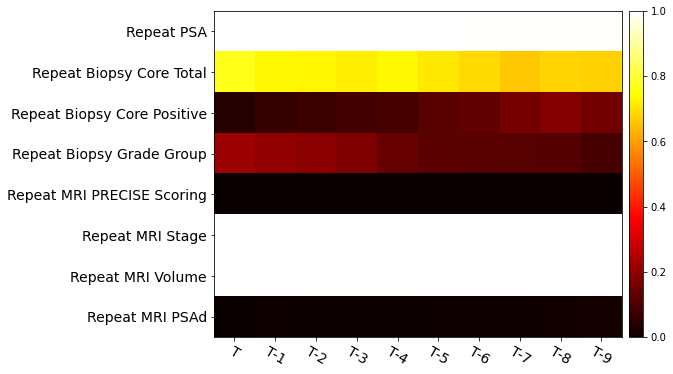

In [319]:
xticks = ['T'] + ['T-{}'.format(t) for t in range(1, 10)]

import matplotlib.pyplot as plt

fig=plt.figure(figsize=[10, 6])
ax = plt.axes()
im = ax.imshow(np.nanmean(importance_t, axis=0)[:10, 1:].T, cmap='hot')

ax.set_yticklabels(feat_timevarying, fontsize=14)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xticks, fontsize=14, rotation=-30)

# Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
# You can change 0.01 to adjust the distance between the main image and the colorbar.
# You can change 0.02 to adjust the width of the colorbar.
# This practice is universal for both subplots and GeoAxes.

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

plt.savefig('./temporal_feat_importance.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

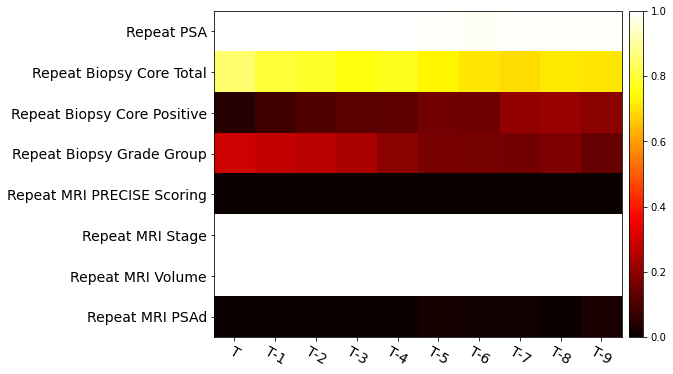

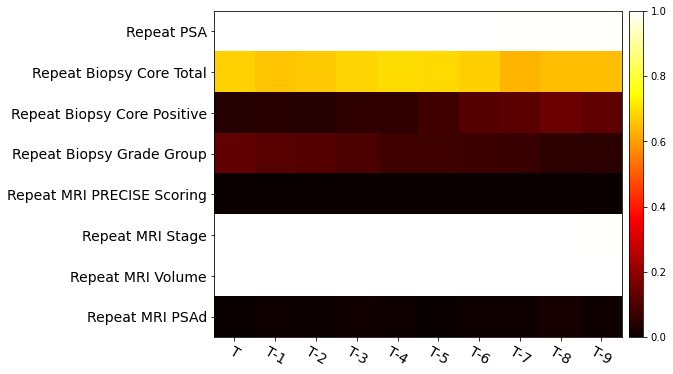

In [320]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=[10, 6])
ax = plt.axes()
im = ax.imshow(np.nanmean(importance_t[idx1], axis=0)[:10, 1:].T, cmap='hot')

ax.set_yticklabels(feat_timevarying, fontsize=14)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xticks, fontsize=14, rotation=-30)

# Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
# You can change 0.01 to adjust the distance between the main image and the colorbar.
# You can change 0.02 to adjust the width of the colorbar.
# This practice is universal for both subplots and GeoAxes.

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

plt.savefig('./temporal_feat_importance_group1.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()



fig=plt.figure(figsize=[10, 6])
ax = plt.axes()
im = ax.imshow(np.nanmean(importance_t[idx0], axis=0)[:10, 1:].T, cmap='hot')

ax.set_yticklabels(feat_timevarying, fontsize=14)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xticks, fontsize=14, rotation=-30)

# Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
# You can change 0.01 to adjust the distance between the main image and the colorbar.
# You can change 0.02 to adjust the width of the colorbar.
# This practice is universal for both subplots and GeoAxes.

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

plt.savefig('./temporal_feat_importance_group0.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()


In [232]:
importance_t = np.nan * np.zeros_like(pit) #reversed based! patest first and then...

for i in range(len(pit)):
    count = 0
    for t_idx in range(int(seq_length[i])-1, -1, -1):
        importance_t[i, count, :] = np.clip(pit[i, t_idx, :], 0, 1)
        count += 1

In [86]:
np.percentile(pis[:, :], 50, axis=0)

array([-3.81596584, -4.98551316,  2.53582792, -4.76557508, -1.58643203,
       -2.59133193,  1.91135802])

In [87]:
feat_static[-1]

'PI-RADS score'

In [92]:
np.percentile(pit[m1 == 1, :], 90, axis=0)

array([-21.7552578 ,   7.84573507,   8.37921095, -10.22259712,
         2.52808366, -15.66549263,  13.53983746,  19.52410126,
       -31.80605164])

In [93]:
np.percentile(pit[m2 == 1, :], 90, axis=0)

array([-8.16124573,  7.36505852,  9.13843269,  2.26683779,  2.01254854,
       -6.54097137, 12.99645996, 19.02597046, -4.34285069])

In [79]:
feat_timevarying[7]

'Repeat MRI Volume'

(array([[ 28.,  86., 113., 121.,  26.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   6.,  14.,  27., 107., 146.,  51.,  16.,   7.,   0.],
        [  0.,   0.,  10.,  63., 134., 112.,  41.,  14.,   0.,   0.],
        [  0.,  13.,  58.,  81., 131.,  89.,   2.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  15., 240.,  66.,  15.,  37.,   1.],
        [  0.,   0.,  97., 186.,  88.,   3.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  19.,  56., 123., 118.,  46.,  12.,   0.,   0.],
        [  6.,  44.,  85.,  99.,  92.,  40.,   8.,   0.,   0.,   0.],
        [  0.,   1.,  21.,  38.,  36.,  73., 109.,  78.,  13.,   5.]]),
 array([-19.60715   , -16.669136  , -13.731124  , -10.793112  ,
         -7.8550997 ,  -4.917087  ,  -1.9790747 ,   0.95893776,
          3.8969502 ,   6.8349624 ,   9.772975  ], dtype=float32),
 <a list of 9 BarContainer objects>)

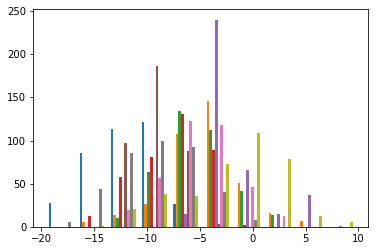

In [190]:
import matplotlib.pyplot as plt

plt.hist(pit[:, 6])

In [35]:
tmp = sess.run(model.stg_temporal, feed_dict={model.mb_size:np.shape(xs_mb)[0], model.xs:xs_mb, model.xt:xt_mb, model.keep_prob:1., model.sigma:0.5, model.is_training:False})

In [38]:
tmp = sess.run(model.stg_static, feed_dict={model.mb_size:np.shape(xs_mb)[0], model.xs:xs_mb, model.xt:xt_mb, model.keep_prob:1., model.sigma:0.5, model.is_training:False})

In [39]:
tmp

array([[0.52863646, 0.27497283, 0.7518282 , 0.8620914 , 0.31746787,
        0.46609917, 0.43423146, 0.76068336],
       [0.505622  , 0.3343088 , 0.8259833 , 0.9056604 , 0.40365243,
        0.30764395, 0.20410752, 0.93374133],
       [0.47602144, 0.4053411 , 0.57718337, 0.7020034 , 0.43890187,
        0.40890932, 0.45193303, 0.6743031 ],
       [0.4757424 , 0.36262426, 0.6731629 , 0.69609016, 0.41203612,
        0.38665304, 0.40043074, 0.7027393 ],
       [0.45264804, 0.42828086, 0.5840546 , 0.7103497 , 0.4040494 ,
        0.37161443, 0.4250875 , 0.6854376 ],
       [0.46952802, 0.40558946, 0.5105105 , 0.6184838 , 0.46566913,
        0.39939412, 0.43095115, 0.72194123],
       [0.54515505, 0.41863883, 0.63389695, 0.67397904, 0.44795275,
        0.3255075 , 0.31090948, 0.8018453 ],
       [0.4818963 , 0.2749163 , 0.8628638 , 0.9205111 , 0.31043723,
        0.4865536 , 0.43202406, 0.8165212 ],
       [0.4765873 , 0.43229836, 0.51547575, 0.64746404, 0.4579543 ,
        0.39479008, 0.429917

(array([ 1.,  0.,  1., 14., 19.,  5.,  4.,  1.,  9., 10.]),
 array([0.5207928 , 0.56259567, 0.6043986 , 0.6462015 , 0.6880044 ,
        0.72980726, 0.7716102 , 0.8134131 , 0.85521597, 0.8970189 ,
        0.9388218 ], dtype=float32),
 <BarContainer object of 10 artists>)

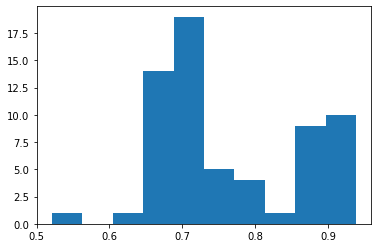

In [37]:
import matplotlib.pyplot as plt

plt.hist(tmp[:, 3])